<a href="https://colab.research.google.com/github/le-pigeon/fantastic-winner/blob/main/Testing_deep_unrolled_algo__supervised_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab test

In [4]:
# empty for debug/admin


🔥 Torch: 2.6.0+cu124
🔥 Torchvision: 0.21.0+cu124
🔥 NumPy: 2.0.2
🔥 OpenCV: 4.11.0
🔥 Matplotlib: 3.10.0
🔥 TQDM: 4.67.1
🔥 Pillow: 11.1.0
🔥 SciPy: 1.14.1
🔥 Scikit-Image: 0.25.2
🔥 Pandas: 2.2.2


In [3]:
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import random

In [2]:
# If you wanna clear cache.. idk sometimes still high RAM :[
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
import zipfile
import os

# drive.mount('/content/drive')  # Connect to your Google Drive

# Step 2: Define Paths
#zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/UCMerced_LandUse.zip"  # Adjust path if needed
# extract_path = "/content/test_data/UCMerced_SAR_Dataset"  # Where to extract
zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/SAR_paired.zip"
extract_path = "/content/test_data/SAR_Dataset"  # Where to extract


# Step 3: Extract ZIP
print("🔥 Extracting dataset... this may take a moment!")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

# Step 4: Verify Files
print("Checking extracted files...")
print(os.listdir(extract_path)[:10])  # Show first 10 files/folders

🔥 Extracting dataset... this may take a moment!
✅ Extraction complete!
📂 Checking extracted files...
['SAR despeckling filters dataset']


In [4]:
# Colab-ready PyTorch Implementation of SAR-DURNet (Deep Unrolling for SAR Despeckling)
# This script trains a deep unrolling network for SAR despeckling.
# Steps:
# 0. Pay for premium GPU :)
# 1. Set up dataset (simulated speckle noise on optical images)
# 2. Define SAR-DURNet model
# 3. Train with Charbonnier + Total Variation loss
# 4. Test on real SAR images



# Automatically select CPU if no GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

🔥 Using device: cuda


In [5]:
###############################################################################
############################## PAIRED DATASET #################################
###############################################################################

# Load to CPU RAM first
noisy_images = []
clean_images = []

# Path to your folders
noisy_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy"
clean_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/GTruth"

# Load all image paths
noisy_paths = sorted(glob.glob(os.path.join(noisy_folder, "*.tiff")))
clean_paths = sorted(glob.glob(os.path.join(clean_folder, "*.tiff")))

# Load the images to CPU RAM
for noisy_path, clean_path in zip(noisy_paths, clean_paths):
    noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE) / 255.0
    clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE) / 255.0

    # Store as torch tensors (but stay in CPU RAM)
    noisy_images.append(torch.tensor(noisy).unsqueeze(0))  # (1, H, W)
    clean_images.append(torch.tensor(clean).unsqueeze(0))  # (1, H, W)

print(f"Loaded {len(noisy_images)} noisy-clean SAR image pairs to CPU RAM!")


class PairedSARDataset(Dataset):
    def __init__(self, noisy_images, clean_images):
        self.noisy_images = noisy_images
        self.clean_images = clean_images

    def __getitem__(self, index):
        noisy = self.noisy_images[index]
        clean = self.clean_images[index]

        # Move to GPU only when accessed
        return noisy.float(), clean.float()


    def __len__(self):
        return len(self.noisy_images)



🔥 Loaded 1500 noisy-clean SAR image pairs to CPU RAM!


In [6]:
# Create Paired Dataset
train_dataset = PairedSARDataset(noisy_images, clean_images)

train_loader = DataLoader(train_dataset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)  # Pin to CPU RAM

print(f"Ready to train on {len(train_dataset)} images!")


✅ Ready to train on 1500 images!


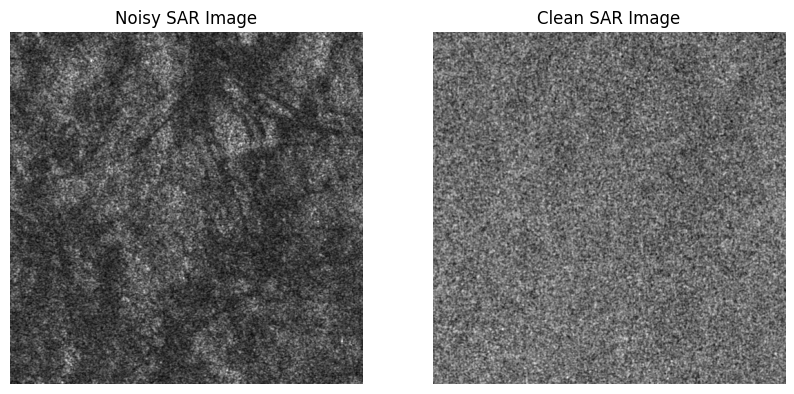

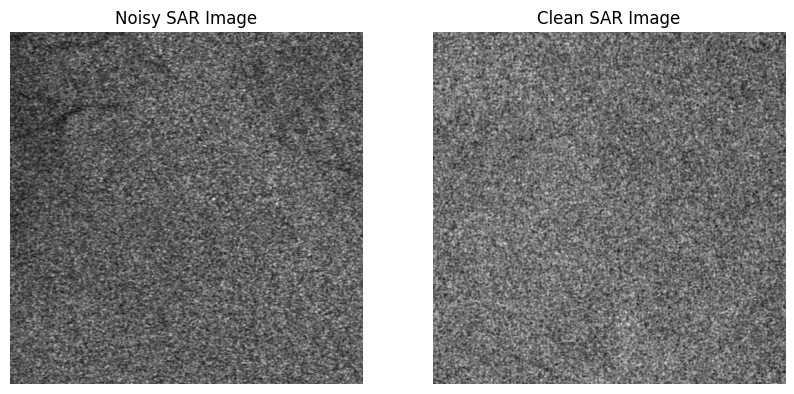

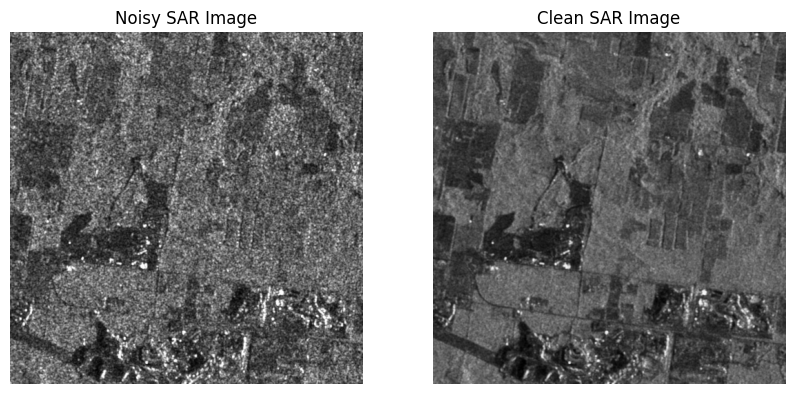

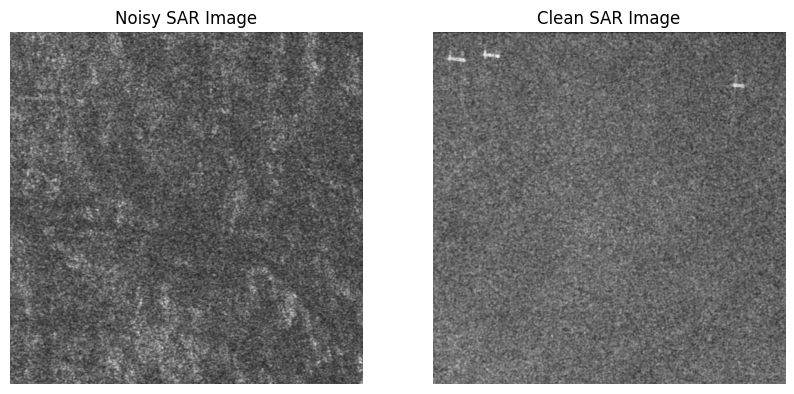

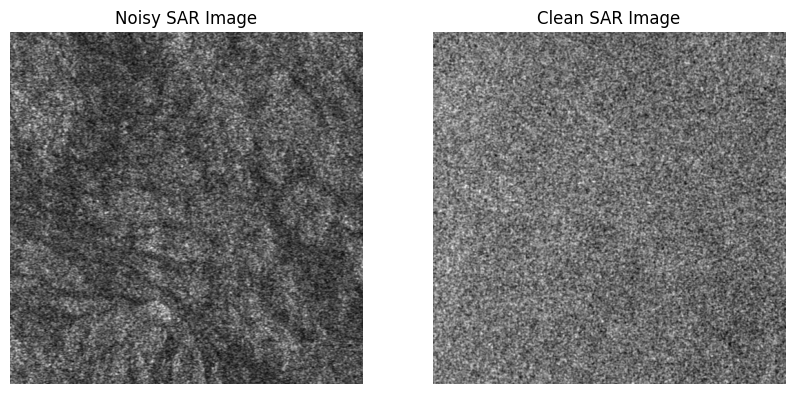

In [7]:
# Peek at training images OwO

import matplotlib.pyplot as plt
import random

# Function to show images
def show_random_images(noisy_images, clean_images, num_samples=5):
    """Display random noisy and clean SAR images."""
    indices = random.sample(range(len(noisy_images)), num_samples)

    for idx in indices:
        noisy = noisy_images[idx].squeeze().cpu().numpy()
        clean = clean_images[idx].squeeze().cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(noisy, cmap='gray')
        plt.title("Noisy SAR Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(clean, cmap='gray')
        plt.title("Clean SAR Image")
        plt.axis("off")

        plt.show()

# Show 10 random images from the dataset
show_random_images(noisy_images, clean_images)

In [8]:
# improved upon with autoencoder further below

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Downsampling
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Deeper features
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid()  # Normalize output between [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Residual U-Net (ResUNet) for SAR despeckling,
# Modified implementation from SAR2SAR

class ResUNet(nn.Module):
    def __init__(self, channels=1):
        super(ResUNet, self).__init__()

        # Encoder Path
        self.enc1 = self.conv_block(channels, 48)
        self.enc2 = self.conv_block(48, 48)
        self.enc3 = self.conv_block(48, 48)
        self.enc4 = self.conv_block(48, 48)
        self.enc5 = self.conv_block(48, 48)

        # Decoder Path
        self.dec5 = self.upconv_block(48, 48)
        self.dec4 = self.upconv_block(48, 48)
        self.dec3 = self.upconv_block(48, 48)
        self.dec2 = self.upconv_block(48, 48)
        self.dec1 = self.conv_block(48, 32)  # Final conv, no upsample!

        # Channel Align 1x1 Convolutions
        self.align4 = nn.Conv2d(48, 48, kernel_size=1)
        self.align3 = nn.Conv2d(48, 48, kernel_size=1)
        self.align2 = nn.Conv2d(48, 48, kernel_size=1)
        self.align1 = nn.Conv2d(48, 48, kernel_size=1)

        # Final Output Layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Fixed upsample method
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1)
        )

    def crop(self, enc_feat, dec_feat):
        """Handles size mismatch due to padding issues."""
        _, _, h, w = dec_feat.size()
        enc_feat = F.interpolate(enc_feat, size=(h, w), mode='bilinear', align_corners=False)
        return enc_feat

    def forward(self, x):
        # Encoder Path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))
        e5 = self.enc5(F.max_pool2d(e4, 2))

        # Decoder Path (with Fixed Skip Connection)
        d5 = self.dec5(e5) + self.crop(e4, self.dec5(e5))
        d4 = self.dec4(d5) + self.crop(e3, self.dec4(d5))
        d3 = self.dec3(d4) + self.crop(e2, self.dec3(d4))
        d2 = self.dec2(d3) + self.crop(e1, self.dec2(d3))
        d1 = self.dec1(d2)

        # Final Output
        return x - self.final_conv(d1)


In [10]:
# Debug to check resUnet output (was broken a few times before hand)
test_input = torch.randn(1, 1, 256, 256)  # Simulated SAR patch
model = ResUNet()
output = model(test_input)

print("ResUNet Output Shape:", output.shape)  # Should match (1, 1, 256, 256)


🔥 ResUNet Output Shape: torch.Size([1, 1, 256, 256])


In [11]:
# ========== 2. SAR-DURNet: Deep Unrolling Model ==========
class SAR_DURNet(nn.Module):
    def __init__(self, num_layers=6):
        super(SAR_DURNet, self).__init__()
        self.num_layers = num_layers
        self.resunet = ResUNet()

        # Unrolling steps
        self.gradient_steps = nn.ModuleList([
            nn.Conv2d(1, 1, kernel_size=3, padding=1) for _ in range(num_layers)
        ])

    def forward(self, x):
        v = x  # Initial guess
        for i in range(self.num_layers):
            noise_est = self.resunet(v)
            x = x - 0.1 * self.gradient_steps[i](noise_est)
            v = torch.relu(x)

        return x - self.resunet(v)

model = SAR_DURNet().to(device)  # Move model to CPU or GPU

# ========== 3. Loss Function & Optimizer ==========
def charbonnier_loss(x, y, epsilon=1e-5):  #  Increase epsilon to prevent division issues
    diff = x - y
    return torch.mean(torch.sqrt(diff ** 2 + epsilon))

def soft_clamp(x, min_val=1e-6):
    return torch.where(x > min_val, x, min_val)

def total_variation_loss(img, epsilon=1e-6):
    """ The New Anti-NaN TV Loss"""
    diff1 = img[:, :, :-1] - img[:, :, 1:]  # Horizontal diff
    diff2 = img[:, :-1, :] - img[:, 1:, :]  # Vertical diff

    # Soft clamp BEFORE sqrt to avoid NaN
    tv_loss = torch.mean(torch.sqrt(soft_clamp(diff1**2) + epsilon)) + \
              torch.mean(torch.sqrt(soft_clamp(diff2**2) + epsilon))

    return tv_loss

def high_freq_loss(output, clean, alpha=0.005):
    fft_output = torch.fft.fft2(output)
    fft_clean = torch.fft.fft2(clean)

    # Add epsilon to avoid NaN from empty frequency
    return alpha * torch.mean(torch.abs(fft_output - fft_clean) + 1e-6)

# Sobel kernels for edge detection
sobel_kernel_x = torch.tensor([[-1, 0, 1],
                               [-2, 0, 2],
                               [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

sobel_kernel_y = torch.tensor([[-1, -2, -1],
                               [ 0,  0,  0],
                               [ 1,  2,  1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

def edge_preserving_loss(output, clean, alpha=0.05):

     # Apply Sobel Filter (No Size Mismatch!)
    grad_output_x = F.conv2d(output, sobel_kernel_x, padding=1)
    grad_output_y = F.conv2d(output, sobel_kernel_y, padding=1)

    grad_clean_x = F.conv2d(clean, sobel_kernel_x, padding=1)
    grad_clean_y = F.conv2d(clean, sobel_kernel_y, padding=1)

    # Magnitude of gradient
    grad_output = torch.sqrt(grad_output_x ** 2 + grad_output_y ** 2 + 1e-6)
    grad_clean = torch.sqrt(grad_clean_x ** 2 + grad_clean_y ** 2 + 1e-6)

    # Edge Loss
    loss = torch.mean((grad_output - grad_clean) ** 2)

    return alpha * loss

def force_even_dim(img):
    """Force SAR patches to even dimensions to avoid edge cropping."""
    h, w = img.shape[-2:]
    if h % 2 != 0:
        img = F.pad(img, (0, 0, 0, 1), mode='reflect')  # Pad height
    if w % 2 != 0:
        img = F.pad(img, (0, 1, 0, 0), mode='reflect')  # Pad width
    return img

optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [12]:
from tqdm import tqdm  # For sexy progress bar
import torch.cuda.memory as cuda_mem

num_epochs = 10  # Set the number of epochs (adjust as needed)

# ========== 4. Training Loop ==========
torch.set_default_tensor_type('torch.FloatTensor')  # Ensure everything is in float32


for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # Free up unused GPU memory

    total_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (noisy, clean) in progress_bar:
        noisy, clean = noisy.float(), clean.float()
        noisy, clean = noisy.to(device, non_blocking=True), clean.to(device, non_blocking=True)

        noisy = force_even_dim(noisy)
        clean = force_even_dim(clean)

        optimizer.zero_grad()
        output = model(noisy)

        #loss = charbonnier_loss(output, clean) + edge_preserving_loss(output, clean)

        loss = charbonnier_loss(output, clean) \
        + 0.2 * edge_preserving_loss(output, clean) \
        + 0.005 * high_freq_loss(output, clean, alpha=0.005)
        + 0.1 * total_variation_loss(output) \

        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Track CUDA memory usage (corrected this maybe)
        gpu_mem = torch.cuda.memory_allocated(device) / 1024**3

        # Update progress bar with loss & GPU usage
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", gpu=f"{gpu_mem:.2f} GB")

        # Show 1 despeckled image every 10 batches
        #if batch_idx % 10 == 0:
            #sample_noisy = noisy[0].squeeze().detach().cpu().numpy()
            #sample_clean = clean[0].squeeze().detach().cpu().numpy()
            #sample_denoised = output[0].squeeze().detach().cpu().numpy()
            # show_images(sample_noisy, sample_denoised, sample_clean)

    # Show average loss at the end of each epoch
    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.6f}\n")


# ========== 5. Save Model ==========
os.makedirs("/content/model", exist_ok=True)  # Create folder if it doesn't exist
torch.save(model.state_dict(), "/content/model/sar_durnet.pth")
print("Model saved!")

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
🔥 Epoch 1/10: 100%|██████████| 188/188 [01:54<00:00,  1.64it/s, gpu=0.02 GB, loss=0.0372]

✅ Epoch 1 | Avg Loss: 0.069902




🔥 Epoch 2/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0418]

✅ Epoch 2 | Avg Loss: 0.041339




🔥 Epoch 3/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0418]

✅ Epoch 3 | Avg Loss: 0.040706




🔥 Epoch 4/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0332]

✅ Epoch 4 | Avg Loss: 0.040344




🔥 Epoch 5/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0399]

✅ Epoch 5 | Avg Loss: 0.039813




🔥 Epoch 6/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0390]

✅ Epoch 6 | Avg Loss: 0.038775




🔥 Epoch 7/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0467]

✅ Epoch 7 | Avg Loss: 0.037477




🔥 Epoch 8/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0308]

✅ Epoch 8 | Avg Loss: 0.036802




🔥 Epoch 9/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0320]

✅ Epoch 9 | Avg Loss: 0.036194




🔥 Epoch 10/10: 100%|██████████| 188/188 [01:53<00:00,  1.66it/s, gpu=0.02 GB, loss=0.0404]

✅ Epoch 10 | Avg Loss: 0.035659

Model saved!


In [ ]:
# Run only if need to empty cache coz this thing uses 40GB of GPU RAM WTF
# I WISH I CAN RUN MY FLIGHT SIMULATOR ON THIS

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Delete model and tensors from memory
del model
del noisy, clean, output
torch.cuda.empty_cache()

# Run garbage collector
gc.collect()

Took about 22min for 20 epochs last time

* Testing for 15 epochs is enough?






In [ ]:
##########################
# To load other models downloaded before
#########################

# Load the trained SAR-DURNet model
model = SAR_DURNet().to(device)

# Load the saved model weights
checkpoint_path = "/content/model/sar_durnet.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode
model.eval()

print("Model successfully loaded!")

In [13]:
# Folder path
folder_name = "/content/imported_images"

# Create if doesn't exist
os.makedirs(folder_name, exist_ok=True)

🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_0.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_1024.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_10240.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_10752.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_11264.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_11776.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_12288.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val/5120_12800.tiff...
🔥 Processing /content/test_data/SAR_Dataset/SAR despeckling filters d

<ipython-input-16-258a39604487>:88: UserWarning: Glyph 128039 (\N{PENGUIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128039 (\N{PENGUIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


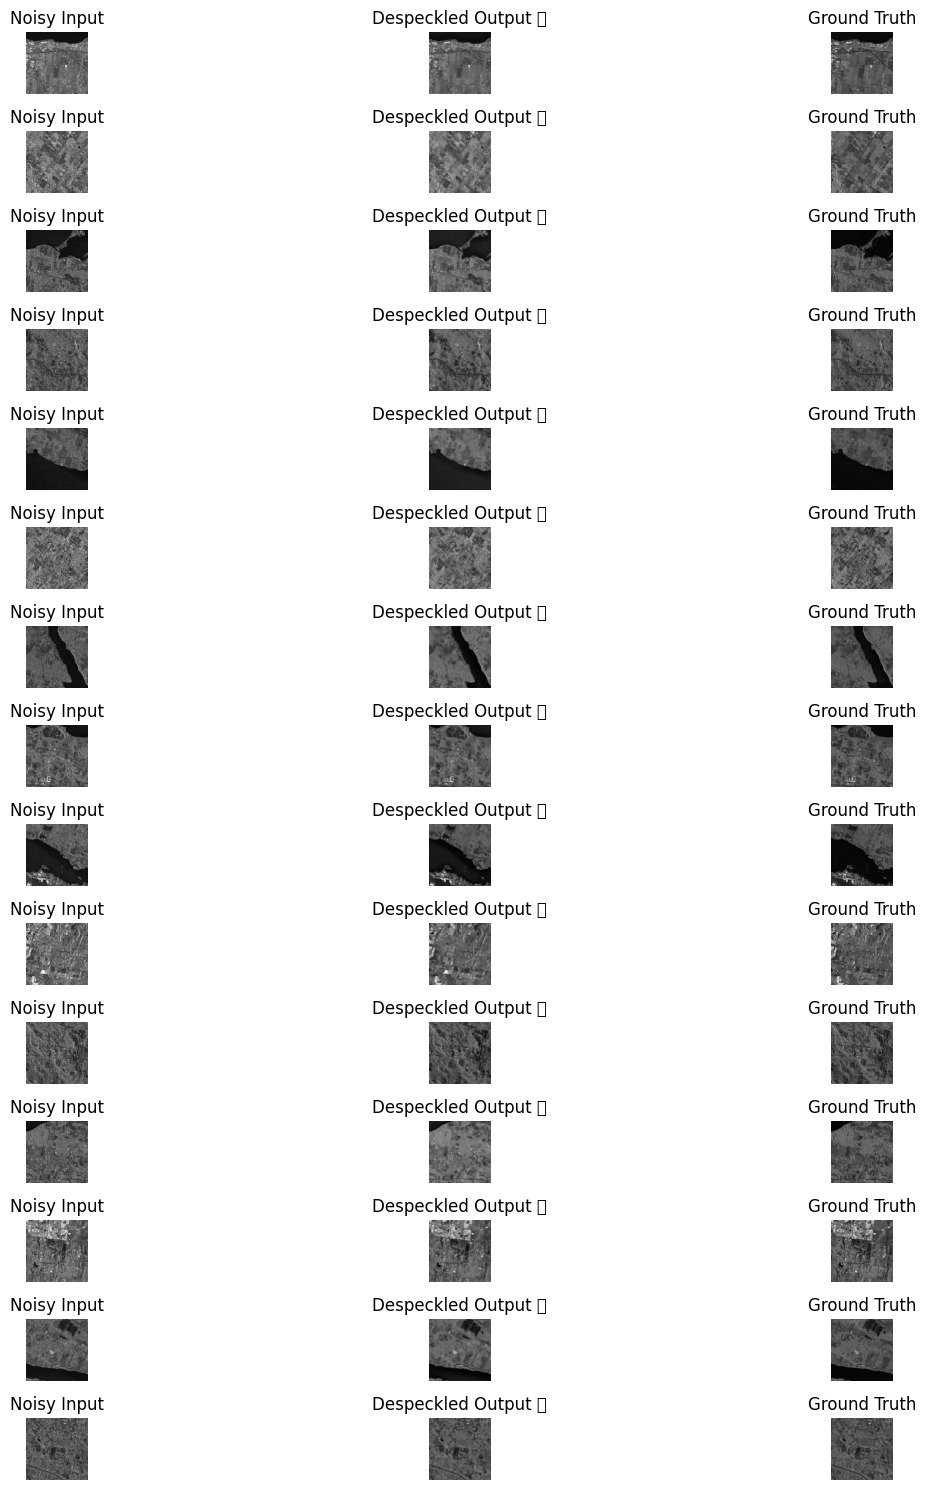

In [16]:
### To test on validation images

import glob
import cv2
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

# Define paths
noisy_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy_val"
clean_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/GTruth_val"
output_folder = "/content/despeckled_val_results"  # Where despeckled images will be saved

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load model in eval mode
model.eval()

# Load noisy & clean image pairs
noisy_images = sorted(glob.glob(noisy_folder + "/*.tiff"))
clean_images = sorted(glob.glob(clean_folder + "/*.tiff"))

assert len(noisy_images) == len(clean_images), "Mismatch in number of noisy and clean images!"

# Store outputs for later visualization
results = []

# Resize to multiple of 32 for U-Net compatibility
def resize_to_multiple_of_32(image):
    h, w = image.shape
    new_h = (h // 32) * 32
    new_w = (w // 32) * 32
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Process each image
for noisy_path, clean_path in zip(noisy_images, clean_images):
    print(f"Processing {noisy_path}...")

    # Load images
    noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE) / 255.0
    clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE) / 255.0

    # Resize
    noisy_resized = resize_to_multiple_of_32(noisy)
    clean_resized = resize_to_multiple_of_32(clean)

    # Convert to tensor
    noisy_tensor = torch.tensor(noisy_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Run through model
    with torch.no_grad():
        despeckled = model(noisy_tensor).squeeze().cpu().numpy()

    # Save despeckled image
    output_path = os.path.join(output_folder, "despeckled_" + os.path.basename(noisy_path))
    cv2.imwrite(output_path, (despeckled * 255).astype(np.uint8))

    # Store for visualization
    results.append((noisy_resized, despeckled, clean_resized))

print("ALL VALIDATION IMAGES PROCESSED!")




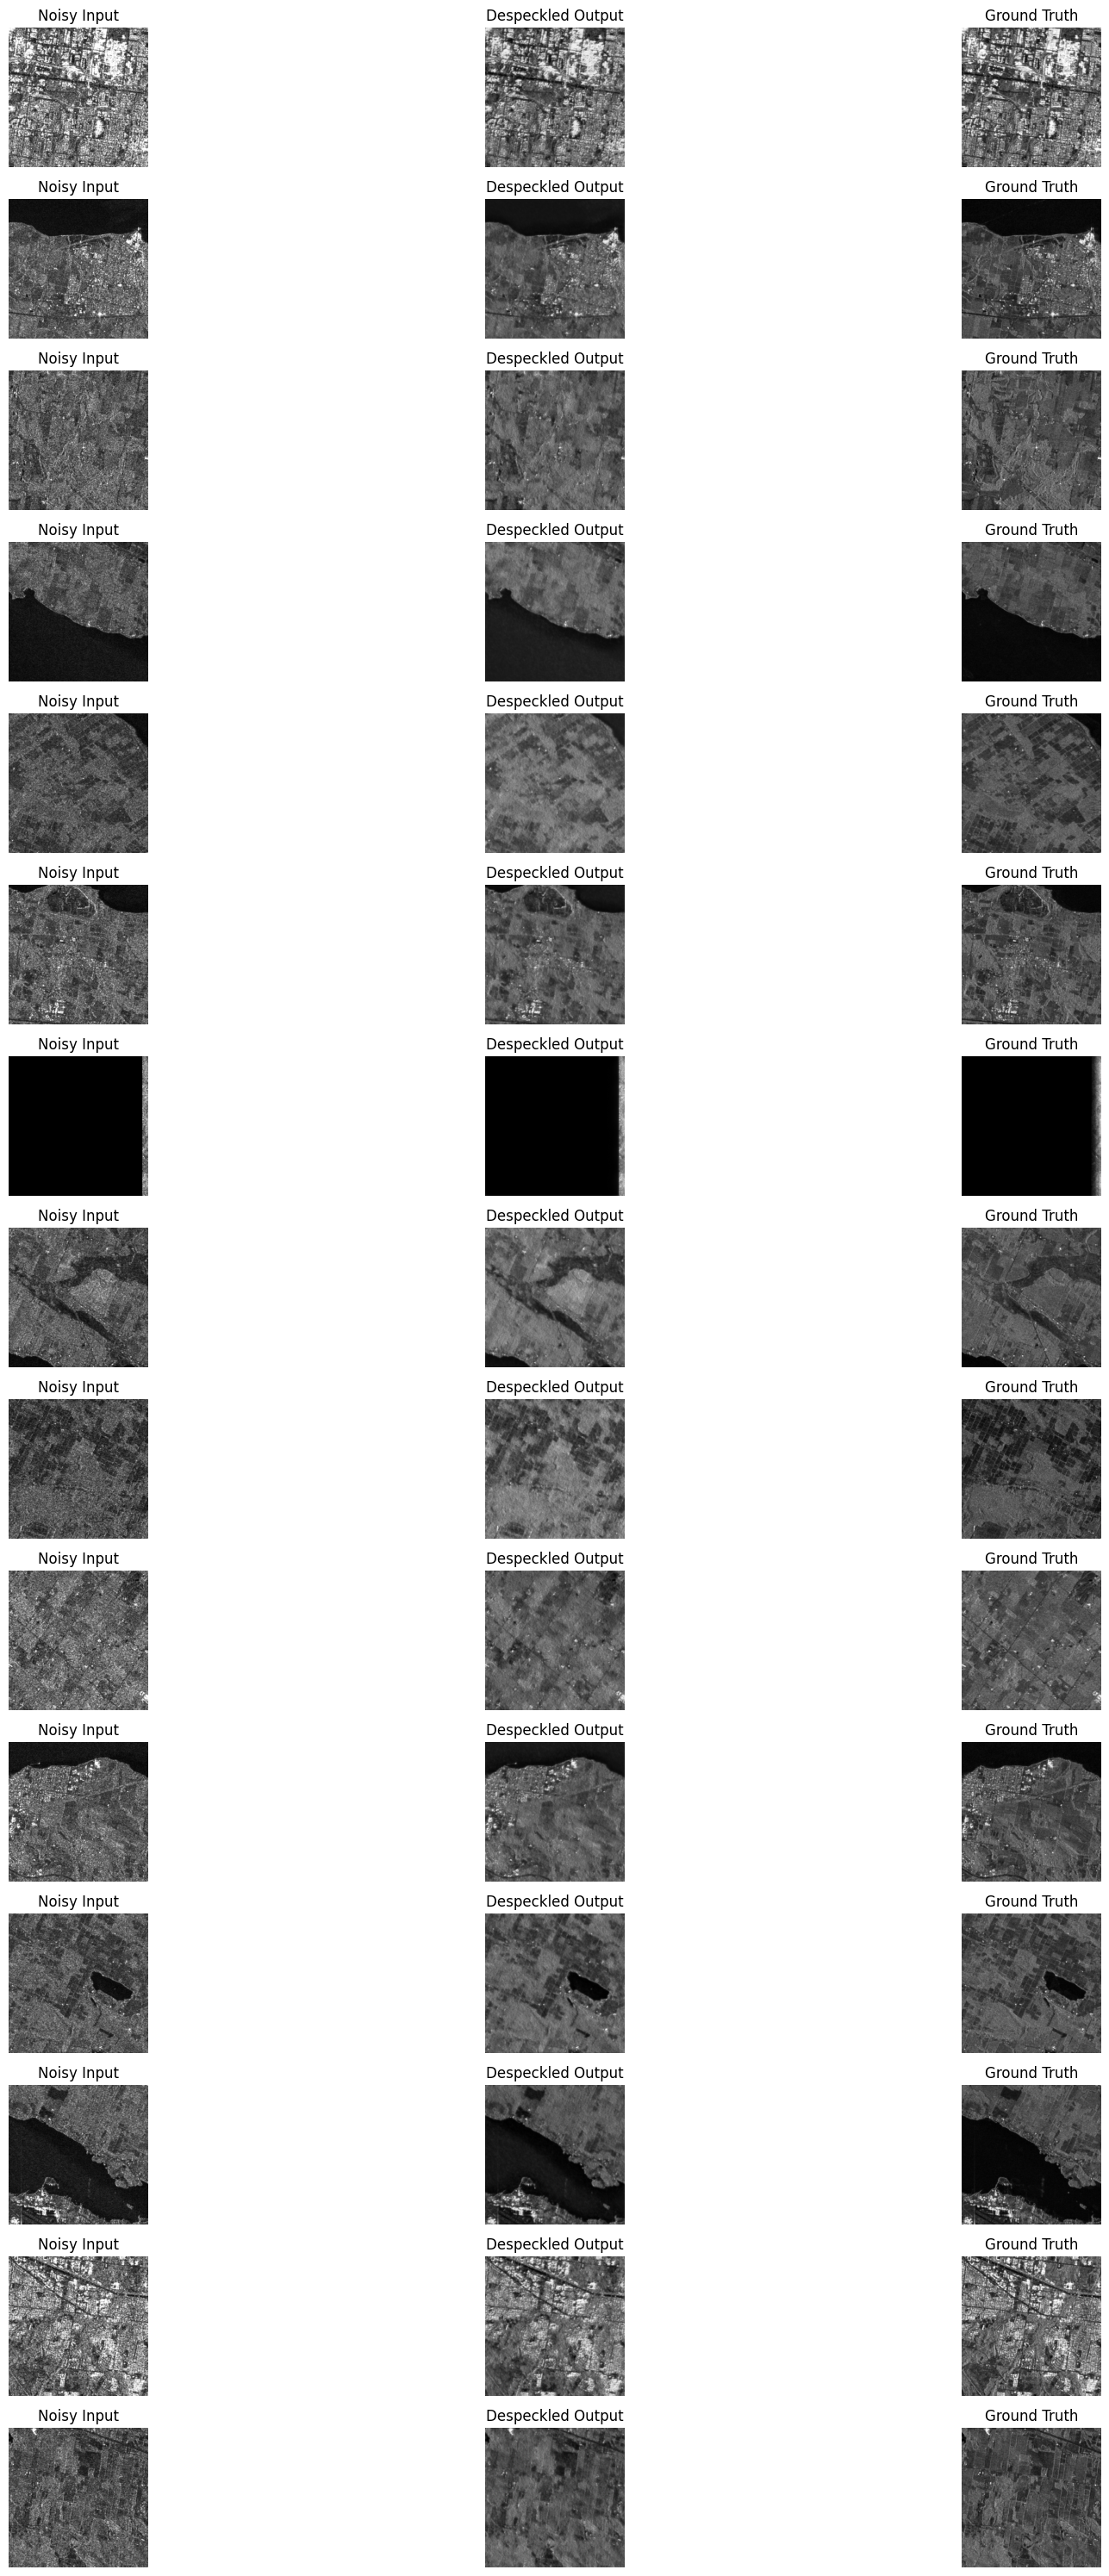

In [17]:
# Show 15 random samples at the end
num_samples = min(15, len(results))
sample_indices = np.random.choice(len(results), num_samples, replace=False)

plt.figure(figsize=(20, 30))
for i, idx in enumerate(sample_indices):
    noisy, despeckled, clean = results[idx]

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(noisy, cmap="gray")
    plt.title("Noisy Input")
    plt.axis("off")

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(despeckled, cmap="gray")
    plt.title("Despeckled Output")
    plt.axis("off")

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(clean, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
# zip output folder to download ezpzggwp

import shutil
shutil.make_archive("/content/despeckled_val_results", 'zip', "/content/despeckled_val_results")

'/content/despeckled_val_results.zip'

🔥 Processing /content/imported_images/SG_Port.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_Port.jpg


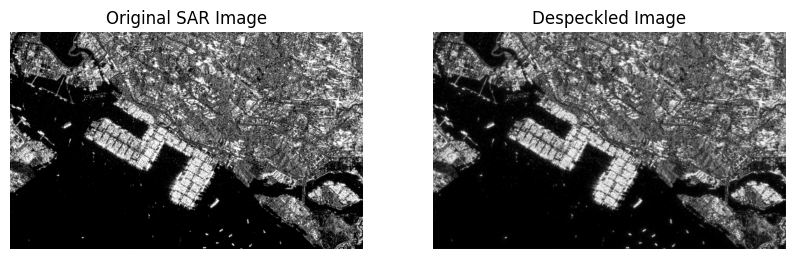

🔥 Processing /content/imported_images/SG_forest.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_forest.tiff


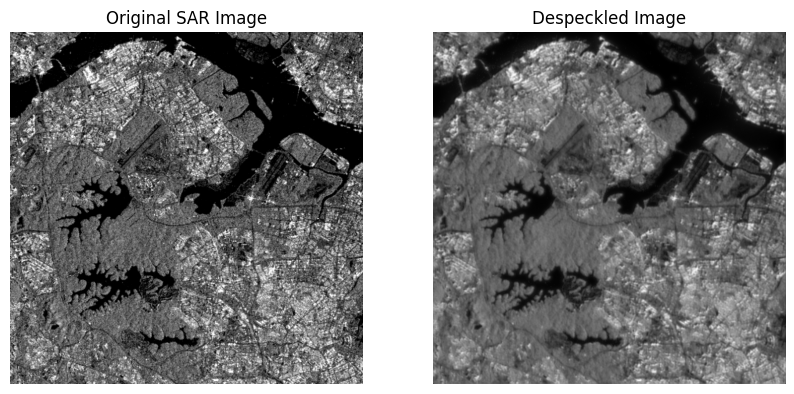

🔥 Processing /content/imported_images/adelaide_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_adelaide_summer.jpg


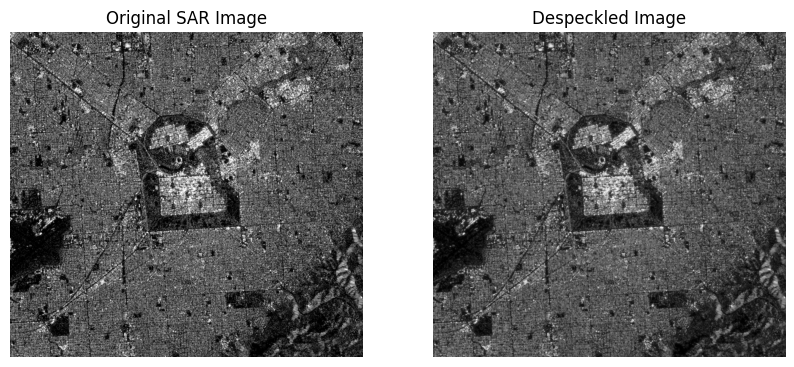

🔥 Processing /content/imported_images/bali_mt.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_bali_mt.tiff


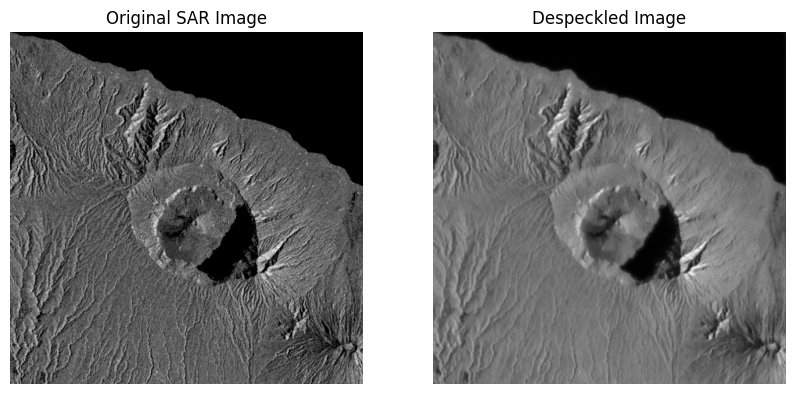

🔥 Processing /content/imported_images/chicago_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_chicago_summer.jpg


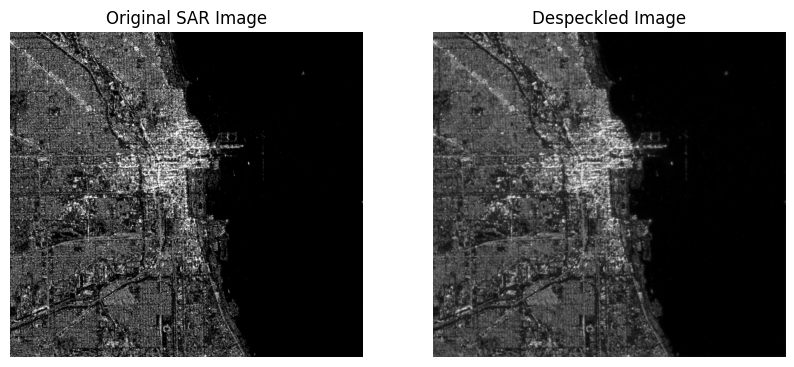

🔥 Processing /content/imported_images/hokkaido_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_summer.jpg


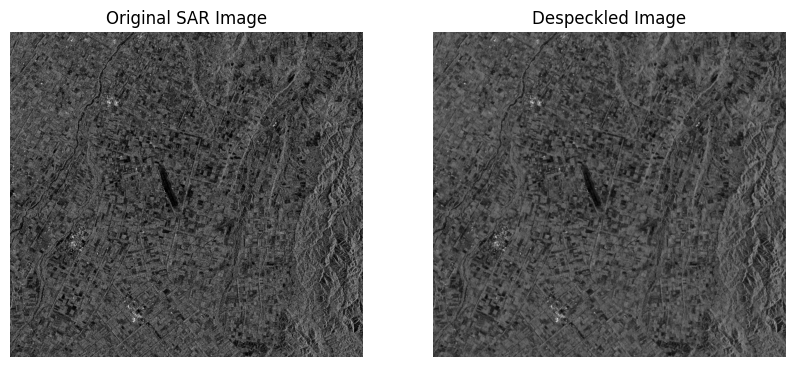

🔥 Processing /content/imported_images/hokkaido_winter.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_winter.jpg


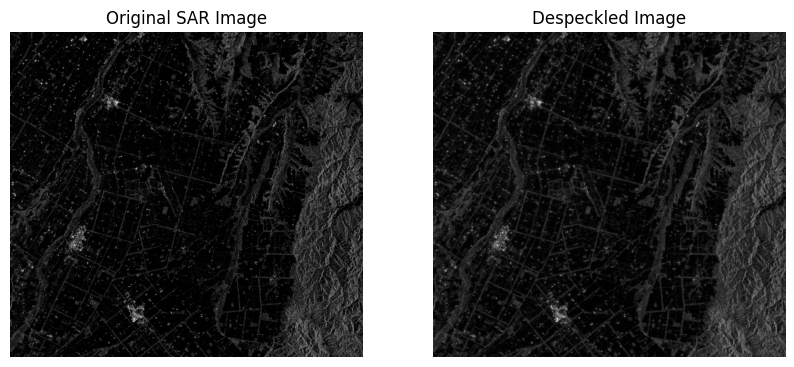

🔥 ALL IMAGES PROCESSED SUCCESSFULLY!


In [14]:
# To test on real SAR iamges (from Sentinel 1 mostly)
import glob
import cv2
import torch
import os
import matplotlib.pyplot as plt

# Define paths
input_folder = "/content/imported_images/"  # Change this to your SAR image folder
output_folder = "/content/despeckled_results/"  # Where despeckled images will be saved

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load model in eval mode
model.eval()

# Find all SAR images in the folder
valid_extensions = ["tiff", "tif", "png", "jpg", "bmp"]
image_paths = sorted(
    [img for ext in valid_extensions for img in glob.glob(os.path.join(input_folder, f"*.{ext}"))]
)
  # Change extension if needed

# Function to resize image to multiple of 32
def resize_to_multiple_of_32(image):
    """Resizes image to the nearest lower multiple of 32 for U-Net compatibility."""
    h, w = image.shape
    new_h = (h // 32) * 32  # Round down to nearest multiple of 32
    new_w = (w // 32) * 32
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Process each image
for img_path in image_paths:
    print(f"Processing {img_path}...")

    # Load image
    test_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if test_image is None:
        print(f"Skipping {img_path}, could not load image!")
        continue

    # Normalize & Resize
    test_image = test_image / 255.0  # Normalize to [0,1]
    test_image_resized = resize_to_multiple_of_32(test_image)

    # Convert to PyTorch tensor
    test_tensor = torch.tensor(test_image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Run through model
    with torch.no_grad():
        despeckled_image = model(test_tensor).squeeze().cpu().numpy()

    # Save the despeckled image
    output_filename = "despeckled_" + os.path.basename(img_path)
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, (despeckled_image * 255).astype(np.uint8))  # Convert back to [0,255]

    print(f"Saved despeckled image to {output_path}")

    # Show Before & After
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image_resized, cmap="gray")
    plt.title("Original SAR Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(despeckled_image, cmap="gray")
    plt.title("Despeckled Image")
    plt.axis("off")

    plt.show()  # Display the images

print("ALL IMAGES PROCESSED SUCCESSFULLY!")


In [19]:
# zip output folder to download ezpzggwp

import shutil
shutil.make_archive("/content/despeckled_results", 'zip', "/content/despeckled_results")

'/content/despeckled_results.zip'